# Bias Buccaneers Image Recognition Challenge: Quickstart

This notebook will introduce you to the data and describe a workflow to train and evaluate a baseline model on it.

## Initial Setup

We start with loading the required packages.

In [ ]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/data_bb1_img_recognition -d /content/

## Load the Data

Make sure to download and uncompress the data (`data_bb1_img_recognition.zip`) in the folder you're working off of.

We first load the file containing the labels, binarize labels of each of the three classes as a numpy array and store them as a list.

In [ ]:
# load data
LOADPATH = './train/'
SAVEPATH = './models/limited/'
df = pd.read_csv(LOADPATH+'labels.csv')
df_labeled = df[df["skin_tone"].notna()] # take only labeled data

# filter for verified humans
df_labeled = df_labeled[df_labeled['real_face'] == '1']


In [ ]:
df_labeled.shape

(4434, 5)

In [ ]:

# Converting labels to np array
cat = ['skin_tone','gender','age']
lbs = [LabelBinarizer() for i in range(3)]
base_Y = []
for i in range(3):
    lab = lbs[i].fit_transform(df_labeled[cat[i]])
    if lab.shape[1]==1:
        base_Y.append(np.hstack((1-lab,lab)))
    else:
        base_Y.append(lab)

We then load the images under the training set and convert them to numpy arrays. This may take a while.

In [ ]:
# loading and converting data into np array
print("Loading images")
length = width = 64 # size for each input image, increase if you want
base_nn = df_labeled.shape[0]
all_imgs = [image.load_img(LOADPATH+df_labeled.iloc[i]['name'], target_size=(length,width)) for i in range(base_nn)]

print("Converting images to np array")
base_X = np.empty([base_nn, length, width, 3], dtype=float)
for i in range(base_nn):
    base_X[i,:] = image.img_to_array(all_imgs[i])
base_X = K.applications.resnet50.preprocess_input(base_X)

Loading images
Converting images to np array


In [ ]:
# Converting to triplicate to match with the different augmentations
base_X = [base_X, base_X, base_X]

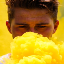

In [ ]:
all_imgs[1235] # print a test image

### Augment the data

In [ ]:
import imgaug.augmenters as iaa
from pathlib import Path
import cv2
from IPython.display import Image


In [ ]:
newseq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
   
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.0),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-8, 8)
    )
], random_order=True)

In [ ]:
def create_aug_names(names: pd.Series, cat: str) -> pd.Series:
    augnames = names.copy()
    for i, name in enumerate(names.values):
        augnames.iloc[i] = "AUG_" + cat + "_" + str(i) + "_" + name
    return augnames


In [ ]:
def get_imgs_to_sample(series: pd.Series) -> pd.Series:
    counts = series.value_counts()
    return counts.max() - counts

In [ ]:
def create_augs(df: pd.DataFrame, img_to_sample: pd.Series, seq: iaa.Sequential, read_dir, write_dir, colname: str = "age") -> pd.DataFrame:
    new_df = pd.DataFrame()
    for cat, count in img_to_sample.items():
        print(f"Sampling {count} images for {colname} {cat}")
        if count > 0:
            df_sample = df[df[colname] == cat].sample(count, replace=True)
            df_sample["aug_name"] = create_aug_names(df_sample["name"], cat)
            df_sample["aug_cat"] = colname
            sample_imgs = [cv2.imread(read_dir + '/' + name) for name in df_sample["name"]]
            augs = seq.augment_images(sample_imgs)
            for i, aug in enumerate(augs):
                cv2.imwrite(str(write_dir + '/' + df_sample.iloc[i, 5]), aug)
            new_df = pd.concat([new_df, df_sample])
    return new_df


In [ ]:
def upsample_imgs(df, sample_cols, seq, read_dir, write_dir):
    aug_df = pd.DataFrame()
    for col in sample_cols:
        print(f"Upsampling {col}")
        counts = df[col].value_counts()
        img_to_sample = 100+counts.max() - counts
        aug_df = pd.concat(
            [
                aug_df,
                create_augs(df, img_to_sample, seq=seq, colname=col, read_dir=read_dir, write_dir=write_dir),
            ]
        )
    return aug_df

In [ ]:
labels = pd.read_csv('./train/labels.csv')
labels = labels[labels["real_face"] == '1'].dropna()
# don't need to run this every time since the images are generated

aug_df = upsample_imgs(labels, sample_cols=cat, seq=newseq, read_dir='./train', write_dir='./augmented_train')
aug_df.to_csv('./augmented_train/labels.csv')

Upsampling skin_tone
Sampling 100 images for skin_tone monk_3
Sampling 148 images for skin_tone monk_4
Sampling 284 images for skin_tone monk_2
Sampling 299 images for skin_tone monk_5
Sampling 627 images for skin_tone monk_7
Sampling 649 images for skin_tone monk_6
Sampling 717 images for skin_tone monk_1
Sampling 732 images for skin_tone monk_8
Sampling 829 images for skin_tone monk_9
Sampling 911 images for skin_tone monk_10
Upsampling gender
Sampling 100 images for gender female
Sampling 948 images for gender male
Upsampling age
Sampling 100 images for age 18_30
Sampling 1111 images for age 31_60
Sampling 1266 images for age 0_17
Sampling 2105 images for age 61_100


In [ ]:
print(labels.shape[0])
print(labels['skin_tone'].value_counts())
print(labels['gender'].value_counts())
print(labels['age'].value_counts())

4434
monk_3     873
monk_4     825
monk_2     689
monk_5     674
monk_7     346
monk_6     324
monk_1     256
monk_8     241
monk_9     144
monk_10     62
Name: skin_tone, dtype: int64
female    2641
male      1793
Name: gender, dtype: int64
18_30     2154
31_60     1143
0_17       988
61_100     149
Name: age, dtype: int64


### Integrate the Augmented Data

In [ ]:
# load data
AUGPATH = './augmented_train/'
aug_df = pd.read_csv(AUGPATH+'labels.csv')
df_aug_labeled = aug_df[aug_df["skin_tone"].notna()] # take only labeled data

# Converting labels to np array
aug_Y = []
for i in range(3):
    lab = lbs[i].transform(df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]][cat[i]])
    if lab.shape[1]==1:
        aug_Y.append(np.hstack((1-lab,lab)))
    else:
        aug_Y.append(lab)

In [ ]:
# loading and converting data into np array
print("Loading images")
length = width = 64 # size for each input image, increase if you want
aug_nn = [0,0,0]
aug_X = [[],[],[]]

for i in range(3):
    aug_nn[i] = df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]].shape[0]
    imgs = [image.load_img(AUGPATH+df_aug_labeled[df_aug_labeled['aug_cat']==cat[i]].iloc[j]['aug_name'], target_size=(length,width)) for j in range(aug_nn[i])]

    print("Converting images to np array")
    aug_X[i] = np.empty([aug_nn[i], length, width, 3], dtype=float)
    for j in range(aug_nn[i]):
        aug_X[i][j,:] = image.img_to_array(imgs[j])
    aug_X[i] = K.applications.resnet50.preprocess_input(aug_X[i])

Loading images
Converting images to np array
Converting images to np array
Converting images to np array


In [ ]:
Y = [[],[],[]]
X = [[],[],[]]

for i in range(len(cat)):
    Y[i] = np.concatenate([base_Y[i], aug_Y[i]])
    X[i] = np.concatenate([base_X[i], aug_X[i]])

nn = base_nn+np.array(aug_nn)

In [ ]:
X[0].shape

(9730, 64, 64, 3)

In [ ]:
Y[0].sum(axis=0)

array([973, 973, 973, 973, 973, 973, 973, 973, 973, 973])

In [ ]:
del base_X, base_Y
del aug_X, aug_Y

## Testing a tiered approach to skin tone

In [ ]:
newY = np.zeros(shape=(Y[0].shape[0],2))
for i, row in enumerate(Y[0]):
     newY[i,0] = row[0:4].sum()
     newY[i,1] = 1 - newY[i,0]
Y.append(newY)
del newY

## Specify the Model

We define a single model class that is able train on the data in `X` and `Y` and predict outcomes for all three classes.

In [ ]:
class CategoricalDisparity(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="disparity", **kwargs):
        super(CategoricalDisparity, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_max - self.acc_min
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalDisparity, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class CategoricalMaxAccuracy(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="max_accuracy", **kwargs):
        super(CategoricalMaxAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_max
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalMaxAccuracy, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class CategoricalMinAccuracy(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="min_accuracy", **kwargs):
        super(CategoricalMinAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_min
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalMinAccuracy, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class PredictionModel():
    def __init__(self, X, Y, idx):
        self.X = X
        self.Y = Y
        self.idx = idx
        self.trainX, self.testX = [X[i][idx[0][i],:] for i in range(3)], [X[i][idx[1][i],:] for i in range(3)]
        self.trainY, self.testY = [Y[i][idx[0][i],:] for i in range(3)], [Y[i][idx[1][i],:] for i in range(3)]
        self.cat = ['skin_tone','gender','age']
        self.loss = ['categorical_crossentropy' for i in range(3)]
        self.metrics = [['accuracy', CategoricalDisparity(num_classes=Y[i][idx[0][i],:].shape[1]),
                         CategoricalMaxAccuracy(num_classes=Y[i][idx[0][i],:].shape[1]),
                         CategoricalMinAccuracy(num_classes=Y[i][idx[0][i],:].shape[1])] for i in range(3)]  # 
        self.models = [None]*3

    # train a model specific for a certain class index in self.cat
    def fit(self, index, model, epochs=5, batch_size=32, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training model for "+self.cat[index])
        
        model.add(K.layers.Dense(self.trainY[index].shape[1], activation='softmax'))
        model.compile(loss=self.loss[index], optimizer='Adam', metrics=self.metrics[index])
        model.fit(
            self.trainX[index], self.trainY[index], 
            validation_data=(self.testX[index],self.testY[index]), 
            batch_size=batch_size, epochs=epochs, verbose=verbose
        )
        
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'model_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        
        self.models[index] = model
        
    # train a model which updates loss weights after each epoch
    def custom_fit(self, index, model, epochs=5, batch_size=32, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training custom weight model for "+self.cat[index])
        
        output_categories = self.trainY[index].shape[1]
        counts = self.trainY[index].sum(axis=0)
        
        model.add(K.layers.Dense(output_categories, activation='softmax'))
        
        loss_weights = np.ones(output_categories)/output_categories
        loss_weights = (loss_weights / counts) / np.sum(loss_weights / counts)
        opt = tf.keras.optimizers.Adam(0.001)
        
        for i in range(epochs):
            print(f"Epoch {i+1}/{epochs}")
            class_weights = dict(enumerate(loss_weights))
            model.compile(loss=self.loss[index], optimizer=opt, metrics=self.metrics[index])
        
            model.fit(
                self.trainX[index], self.trainY[index], 
                validation_data=(self.testX[index],self.testY[index]), 
                batch_size=batch_size, epochs=1, verbose=verbose,
                class_weight = class_weights
            )

            predy = np.argmax(model.predict(self.trainX[index]),1)
            truey = np.argmax(self.trainY[index],1)
            cats = max(truey) + 1
            accs = np.zeros(cats)
            for i in range(cats):
                accs[i] = np.sum((predy==truey) & (truey==i))/np.sum(truey==i)
            epsilon = 1
            
            loss_weights = (1/(accs + epsilon))
            loss_weights = (loss_weights) / np.sum(loss_weights)
            print(np.round(accs,2))
            print(np.round(loss_weights,2))
            
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'custommodel_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        
        self.models[index] = model
            
    def predict(self, newX):
        predictions = [model.predict(newX) for model in self.models]
        return predictions

## Initialize and Train a Model

We now train a `PredictionModel` to predict the likely skin tone, gender, and age of an input image. This baseline model is initialize on imagenet weights and uses the ResNet50 architecture. We strongly recommend using a GPU to reduce training time.

In [ ]:
# function to initialize a model
def initializeModel():
    res_model = ResNet50(include_top=False, weights='imagenet', input_tensor=K.Input(shape=[length,width,3]))

    # freeze all but the last layer
    for layer in res_model.layers[:143]:
        layer.trainable = False
    model = K.models.Sequential()
    model.add(res_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(512, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(512, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    #model.add(K.layers.Dense(256, activation='relu'))
    #model.add(K.layers.Dropout(0.5))
    #model.add(K.layers.BatchNormalization())
    return model

nntrain = [[],[],[]]
indices = [[],[],[]]
train_idx = [[],[],[]]
test_idx = [[],[],[]]

for i in range(3):
    nntrain[i] = int(0.7*nn[i])
    np.random.seed(42)
    indices = np.random.permutation(nn[i])
    train_idx[i], test_idx[i] = indices[:nntrain[i]], indices[nntrain[i]:]



In [ ]:
del mymodel

In [ ]:
mymodel = PredictionModel(X=X, Y=[Y[4],Y[1],Y[2]], idx=[train_idx,test_idx])

In [ ]:
# train model
mymodel.fit(index=0, model=initializeModel(), epochs=20, save=True, save_location='./content/drive/MyDrive/face_bounty/models/')

Training model for skin_tone
Epoch 1/20
213/213 [==============================] - 17s 52ms/step - loss: 0.8243 - accuracy: 0.5984 - disparity: 0.1614 - max_accuracy: 0.6565 - min_accuracy: 0.4951 - val_loss: 3.1119 - val_accuracy: 0.5735 - val_disparity: 0.2217 - val_max_accuracy: 0.7029 - val_min_accuracy: 0.4812
Epoch 2/20
213/213 [==============================] - 9s 45ms/step - loss: 0.6079 - accuracy: 0.6933 - disparity: 0.0960 - max_accuracy: 0.7268 - min_accuracy: 0.6308 - val_loss: 0.6371 - val_accuracy: 0.7335 - val_disparity: 0.0257 - val_max_accuracy: 0.7417 - val_min_accuracy: 0.7160
Epoch 3/20
213/213 [==============================] - 9s 45ms/step - loss: 0.4932 - accuracy: 0.7740 - disparity: 0.0781 - max_accuracy: 0.8038 - min_accuracy: 0.7257 - val_loss: 0.5185 - val_accuracy: 0.7568 - val_disparity: 0.1199 - val_max_accuracy: 0.8082 - val_min_accuracy: 0.6882
Epoch 4/20
213/213 [==============================] - 9s 44ms/step - loss: 0.4130 - accuracy: 0.8156 - dispar

In [ ]:
# train model
#mycustommodel = PredictionModel(X=X, Y=Y, idx=[train_idx,test_idx])
#mycustommodel.custom_fit(index=0, model=initializeModel(), epochs=20, save=True, save_location='./models/test/custom/')

In [ ]:
# train model
mymodel.fit(index=1, model=initializeModel(), epochs=20, save=True, save_location='./models/test/base/')

Training model for gender
Epoch 1/20
120/120 [==============================] - 14s 66ms/step - loss: 0.6238 - accuracy: 0.7464 - disparity: 0.0059 - max_accuracy: 0.7494 - min_accuracy: 0.7434 - val_loss: 1.0360 - val_accuracy: 0.8195 - val_disparity: 0.0474 - val_max_accuracy: 0.8441 - val_min_accuracy: 0.7967
Epoch 2/20
120/120 [==============================] - 5s 45ms/step - loss: 0.4104 - accuracy: 0.8254 - disparity: 0.0118 - max_accuracy: 0.8314 - min_accuracy: 0.8197 - val_loss: 0.4986 - val_accuracy: 0.8371 - val_disparity: 0.0095 - val_max_accuracy: 0.8420 - val_min_accuracy: 0.8326
Epoch 3/20
120/120 [==============================] - 5s 45ms/step - loss: 0.3112 - accuracy: 0.8819 - disparity: 0.0118 - max_accuracy: 0.8880 - min_accuracy: 0.8762 - val_loss: 0.5675 - val_accuracy: 0.8103 - val_disparity: 0.1816 - val_max_accuracy: 0.9231 - val_min_accuracy: 0.7414
Epoch 4/20
120/120 [==============================] - 5s 45ms/step - loss: 0.2074 - accuracy: 0.9179 - disparity

In [ ]:
# train model
mymodel.fit(index=2, model=initializeModel(), epochs=20, save=True, save_location='./models/test/base/')

Training model for age
Epoch 1/20
198/198 [==============================] - 16s 55ms/step - loss: 1.2600 - accuracy: 0.5154 - disparity: 0.2632 - max_accuracy: 0.6356 - min_accuracy: 0.3724 - val_loss: 1.5137 - val_accuracy: 0.6251 - val_disparity: 0.2574 - val_max_accuracy: 0.7809 - val_min_accuracy: 0.5235
Epoch 2/20
198/198 [==============================] - 9s 44ms/step - loss: 0.9080 - accuracy: 0.6314 - disparity: 0.3024 - max_accuracy: 0.7946 - min_accuracy: 0.4922 - val_loss: 0.7958 - val_accuracy: 0.6721 - val_disparity: 0.3242 - val_max_accuracy: 0.8153 - val_min_accuracy: 0.4911
Epoch 3/20
198/198 [==============================] - 9s 45ms/step - loss: 0.7428 - accuracy: 0.6981 - disparity: 0.2967 - max_accuracy: 0.8647 - min_accuracy: 0.5680 - val_loss: 0.7528 - val_accuracy: 0.6939 - val_disparity: 0.2625 - val_max_accuracy: 0.8570 - val_min_accuracy: 0.5944
Epoch 4/20
198/198 [==============================] - 9s 45ms/step - loss: 0.6187 - accuracy: 0.7585 - disparity: 0

## Evaluate the Model

We now evaluate the model on the test data. To do this, let's first load up that data and structure it similarly.

In [ ]:
# load labels data
TESTPATH = './test/'
df_test = pd.read_csv(TESTPATH+'labels.csv')

# Convert labels to np array
print("Converting test labels to np array")
testY = []
for i in range(3):
    lab = lbs[i].fit_transform(df_test[cat[i]])
    if lab.shape[1]==1:
        testY.append(np.hstack((1-lab,lab)))
    else:
        testY.append(lab)
        
# load and convert images into np array
print("Loading test images")
nt = df_test.shape[0]
all_imgs = [image.load_img(TESTPATH+df_test.iloc[i]['name'], target_size=(length,width)) for i in range(nt)]

print("Converting test images to np array")
testX = np.empty([nt, length, width, 3], dtype=float)
for i in range(nt):
    testX[i,:] = image.img_to_array(all_imgs[i])
testX = K.applications.resnet50.preprocess_input(testX)

Converting test labels to np array
Loading test images
Converting test images to np array


In [ ]:
face_indices = df_test['real_face'] == 1
fake_indices = df_test['real_face'] != 1

We also need to reload the model:

In [ ]:
if False:
  loaded_models = [[],[],[]]
  pred = [[],[],[]]

  custom_objects = {"CategoricalDisparity": CategoricalDisparity, "CategoricalMaxAccuracy": CategoricalMaxAccuracy, "CategoricalMinAccuracy":CategoricalMinAccuracy}
  for i in range(3):
      models[i] = K.models.load_model('./models/test/base/' + 'model_'+cat[i]+'.h5', custom_objects=custom_objects)
      pred[i] = models[i].predict(testX[i])    
    
      predY = [[np.argmax(pred[i][j,:]) for j in range(nt)] for i in range(3)]

We then obtain predicted labels for skin tone, gender, and age as a list of lists.

In [ ]:
pred = mymodel.predict(testX)
predY = [[np.argmax(pred[i][j,:]) for j in range(nt)] for i in range(3)]
predLabels = [[lbs[i].classes_[j] for j in predY[i]] for i in range(3)]

94/94 [==============================] - 3s 17ms/step


Finally, we calculate the label-wise accuracy and disparity.

In [ ]:
# calculate accuracy
acc = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[cat[i]], predLabels[i])
    acc[icat] = iacc
    
# calculate disparity
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)

disp = {}
for i in range(3):
    icat = cat[i]
    idisp = disparity_score(df_test[cat[i]], predLabels[i])
    disp[icat] = idisp
disp

results = {'accuracy': acc, 'disparity': disp}
results

{'accuracy': {'skin_tone': 0.22566666666666665,
  'gender': 0.7586666666666667,
  'age': 0.5016666666666667},
 'disparity': {'skin_tone': 0.14149345650500386,
  'gender': 0.05861143076332953,
  'age': 0.23206459054209921}}

In [ ]:
import scipy.stats as stats

true_acc = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[face_indices.values][cat[i]], np.array(predLabels[i])[face_indices.values])
    true_acc[icat] = iacc

fake_acc = {}
for i in range(3):
    icat = cat[i]
    obs = pd.Series(predLabels[i])[fake_indices.values].value_counts().values
    e = obs.sum()/len(obs)
    chi2 = ((obs - e)**2 / e).sum()
    iacc = 1 - stats.chi2.cdf(chi2, df=len(obs)-1)
    fake_acc[icat] = iacc


In [ ]:
print({'true_accuracy': true_acc, 'fake_chi': fake_acc})

{'true_accuracy': {'skin_tone': 0.2431791221826809, 'gender': 0.8113879003558719, 'age': 0.5272835112692764}, 'fake_chi': {'skin_tone': 0.0, 'gender': 7.11197676709352e-05, 'age': 0.0}}


skin_tone


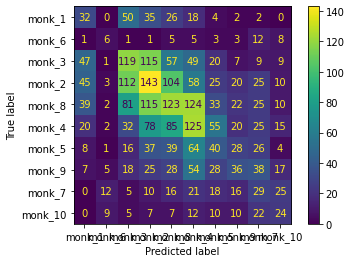

gender


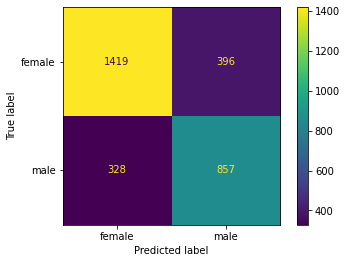

age


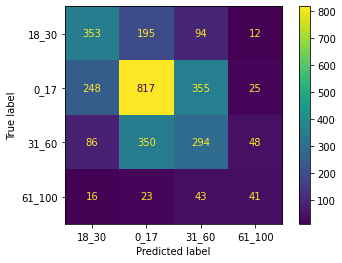

In [ ]:
import matplotlib.pyplot as plt

for i in range(3):
    labels = df[df[cat[i]].notna()][cat[i]].unique()
    print(cat[i])
    ConfusionMatrixDisplay(confusion_matrix(df_test[cat[i]], predLabels[i]),display_labels=labels).plot()
    plt.show()

# Score Model and Prepare Submission

Based on the above metric, we now calculate the score to evaluate your submission. This score will be displayed in your public leaderboard.

In [ ]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

title = 'OII Crew'
    
submission = {
    'submission_name': title,
    'score': getScore(results),
    'metrics': results
}

   
submission

{'submission_name': 'OII Crew',
 'score': 5.583538632104858,
 'metrics': {'accuracy': {'skin_tone': 0.22566666666666665,
   'gender': 0.7586666666666667,
   'age': 0.5016666666666667},
  'disparity': {'skin_tone': 0.14149345650500386,
   'gender': 0.05861143076332953,
   'age': 0.23206459054209921}}}

In [ ]:
print(10*.3919*(1-.3422**5))
print(10*.2256*(1-.1415**5))

3.900610272685576
2.2558720261326037


In [ ]:
{'submission_name': 'OII Crew',
 'score': 5.28437039172921,
 'metrics': {'accuracy': {'skin_tone': 0.21466666666666667,
   'gender': 0.7576666666666667,
   'age': 0.5183333333333333},
  'disparity': {'skin_tone': 0.34997984567545776,
   'gender': 0.1225163022631377,
   'age': 0.3500379778884294}}}

Finally, let's export this as a json file to upload as part of filling out your [submission form](https://docs.google.com/forms/d/e/1FAIpQLSfwqtVkJBVRP6TnFp7vHbbH8SlwKZJFIjvGQy7TyYFc8HR1hw/viewform).

In [ ]:
with open("model_score.json", "w") as f:
    json.dump(submission, f, indent=4)